In [0]:
import os
os.chdir('/content/drive/My Drive/FACE RECOGNITION TRAINING')
os.listdir('/content/drive/My Drive/FACE RECOGNITION TRAINING')
# os.mkdir('training_images')

['vgg_face_weights.h5',
 'facenet_weights.h5',
 'inception_resnet_v1.py',
 'training',
 '__pycache__',
 'temp2',
 'known_faces',
 'facenet_BBT.h5',
 'test_images',
 'training_images',
 'test_images (1)']

In [0]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=5a019ae37679298781238ec681ee546fa334d9b3bf6947ce677bc7e210146826
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.initializers import RandomNormal

################
from keras import layers
from keras.layers import Input, Layer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras import backend as K

In [0]:
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def create_model(input_shape):
    X_input = Input(input_shape)

    X = Conv2D(32, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(64, (3, 3), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(128, (3, 3), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(256, (1, 1), name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
    X = Activation('relu')(X)
    
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    
    return Model(inputs=[X_input], outputs=X) 

In [0]:
IMAGE_SIZE = 96
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

convnet = create_model(input_shape)

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [0]:
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

In [0]:
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=RandomNormal(mean=0.5, stddev=1e-2))(L1_distance)

In [0]:
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
optimizer = Adam(0.00006)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
import os
import cv2
import numpy as np
FRAME_THICKNESS = 3
FONT_THICKNESS = 2
TRAINING_FACES_DIR = "training"

def zscore(x):
  mean = np.mean(x)
  std = np.std(x)
  std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
  y = np.multiply(np.subtract(x, mean), 1 / std_adj)
  return y

In [0]:
print("loading faces")

faces = os.listdir(TRAINING_FACES_DIR)
training_images = {}
for name in os.listdir(TRAINING_FACES_DIR):
	temp = []
	for filename in os.listdir(f"{TRAINING_FACES_DIR}/{name}"):
		image = cv2.imread(f"{TRAINING_FACES_DIR}/{name}/{filename}")
		image = cv2.resize(image, input_shape[:-1])
		image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #cv2.COLOR_RGB2BGR
		image = np.expand_dims(image, axis=-1)
		temp.append(zscore(image))
		# temp.append(np.around(image/255, decimals=5))
	training_images[name] = np.array(temp)

loading faces


In [0]:
print("loading validation faces")
VALIDATION_FACES_DIR = "test_images (1)"
validation_faces = os.listdir(VALIDATION_FACES_DIR)
val_images = {}
for name in os.listdir(VALIDATION_FACES_DIR):
	temp = []
	for filename in os.listdir(f"{VALIDATION_FACES_DIR}/{name}"):
		image = cv2.imread(f"{VALIDATION_FACES_DIR}/{name}/{filename}")
		image = cv2.resize(image, input_shape[:-1])
		image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #cv2.COLOR_RGB2BGR
		image = np.expand_dims(image, axis=-1)
		temp.append(zscore(image))
		# temp.append(np.around(image/255, decimals=5))
	val_images[name] = np.array(temp)

loading validation faces


In [0]:
training_images['sheldon'].shape

(48, 96, 96, 1)

In [0]:
def pairs_generator(batch_size):
    y_val = np.zeros((batch_size, 1))
    positives = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
    negatives = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
    while True:
      i = 0
      for i in range(batch_size//2):
        positiveFace = faces[np.random.randint(len(faces))]
        negativeFace = faces[np.random.randint(len(faces))]
        while positiveFace == negativeFace:
          negativeFace = faces[np.random.randint(len(faces))]

        positives[i] =  training_images[positiveFace][np.random.randint(len(training_images[positiveFace]))]
        # plt.imshow(positives[i])
        # plt.show()
        negatives[i] = training_images[negativeFace][np.random.randint(len(training_images[negativeFace]))]
        # plt.imshow(negatives[i])
        # plt.show()
        y_val[i] = 0

      for i in range(i, batch_size):
        positiveFace = faces[np.random.randint(len(faces))]
        negativeFace = faces[np.random.randint(len(faces))]
        while positiveFace != negativeFace:
              negativeFace = faces[np.random.randint(len(faces))]

        positives[i] =  training_images[positiveFace][np.random.randint(len(training_images[positiveFace]))]
        # plt.imshow(positives[i])
        # plt.show()
        negatives[i] = training_images[negativeFace][np.random.randint(len(training_images[negativeFace]))]
        # plt.imshow(negatives[i])
        # plt.show()
        y_val[i] = 1

        yield ([positives, negatives], y_val)

In [0]:
def validation_set(n = 100):
  y_val = np.zeros((n, 1))
  positives = np.zeros((n, input_shape[0], input_shape[1], input_shape[2]))
  negatives = np.zeros((n, input_shape[0], input_shape[1], input_shape[2]))
  i = 0
  for i in range(n//2):
    positiveFace = faces[np.random.randint(len(faces))]
    negativeFace = faces[np.random.randint(len(faces))]
    while positiveFace == negativeFace:
      negativeFace = faces[np.random.randint(len(faces))]

    positives[i] =  val_images[positiveFace][np.random.randint(len(val_images[positiveFace]))]
    # plt.imshow(positives[i])
    # plt.show()
    negatives[i] = val_images[negativeFace][np.random.randint(len(val_images[negativeFace]))]
    # plt.imshow(negatives[i])
    # plt.show()
    y_val[i] = 0

  for i in range(i, n):
    positiveFace = faces[np.random.randint(len(faces))]
    negativeFace = faces[np.random.randint(len(faces))]
    while positiveFace != negativeFace:
          negativeFace = faces[np.random.randint(len(faces))]

    positives[i] =  val_images[positiveFace][np.random.randint(len(val_images[positiveFace]))]
    # plt.imshow(positives[i])
    # plt.show()
    negatives[i] = val_images[negativeFace][np.random.randint(len(val_images[negativeFace]))]
    # plt.imshow(negatives[i])
    # plt.show()
    y_val[i] = 1

  return ([positives, negatives], y_val)

In [0]:
val = validation_set()

In [0]:
x_val, y_val = val

In [0]:
def contrastive_loss(enc_1, enc2):
  

In [0]:
generator = pairs_generator(batch_size=200)
history = siamese_net.fit(generator,
          epochs=50,
          steps_per_epoch=50,
          validation_data=val)

Epoch 1/50
50/50 [==============================] - 17s 337ms/step - loss: 0.3111 - accuracy: 0.7689 - val_loss: 0.6840 - val_accuracy: 0.6600
Epoch 2/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0793 - accuracy: 0.9836 - val_loss: 0.7311 - val_accuracy: 0.6300
Epoch 3/50
50/50 [==============================] - 17s 339ms/step - loss: 0.0485 - accuracy: 0.9950 - val_loss: 0.6799 - val_accuracy: 0.7200
Epoch 4/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0596 - accuracy: 0.9867 - val_loss: 0.7319 - val_accuracy: 0.6900
Epoch 5/50
50/50 [==============================] - 17s 337ms/step - loss: 0.0438 - accuracy: 0.9970 - val_loss: 0.7049 - val_accuracy: 0.7300
Epoch 6/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0571 - accuracy: 0.9867 - val_loss: 0.7582 - val_accuracy: 0.7200
Epoch 7/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0429 - accuracy: 0.9961 - val_loss: 0.7317 - val_accuracy: 0.7300

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

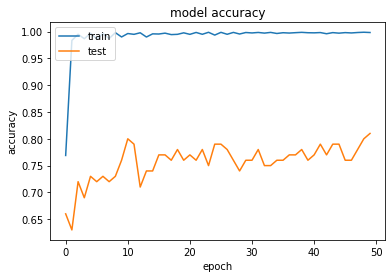

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

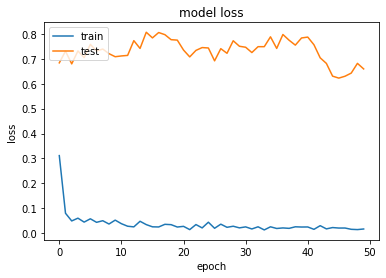

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
history2 = siamese_net.fit(generator,
          epochs=50,
          steps_per_epoch=50,
          validation_data=val)

Epoch 1/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0232 - accuracy: 0.9978 - val_loss: 0.6217 - val_accuracy: 0.8300
Epoch 2/50
50/50 [==============================] - 17s 339ms/step - loss: 0.0145 - accuracy: 0.9984 - val_loss: 0.6449 - val_accuracy: 0.8100
Epoch 3/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0115 - accuracy: 0.9987 - val_loss: 0.6445 - val_accuracy: 0.8200
Epoch 4/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0166 - accuracy: 0.9982 - val_loss: 0.6535 - val_accuracy: 0.7600
Epoch 5/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0192 - accuracy: 0.9982 - val_loss: 0.6466 - val_accuracy: 0.8200
Epoch 6/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0145 - accuracy: 0.9980 - val_loss: 0.6327 - val_accuracy: 0.7800
Epoch 7/50
50/50 [==============================] - 17s 338ms/step - loss: 0.0123 - accuracy: 0.9985 - val_loss: 0.6719 - val_accuracy: 0.8000

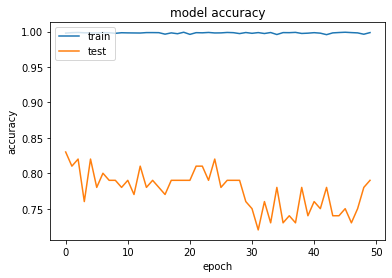

In [0]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

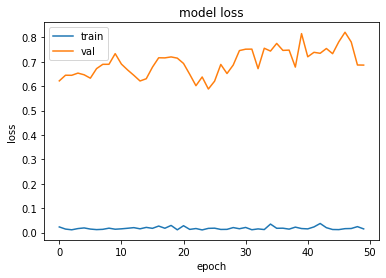

In [0]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
convnet.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 96, 96, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 94, 94, 32)        320       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 94, 94, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 29, 29, 64)        256 

In [0]:
siamese_net.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 256)          390016      input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256)          0           model_8[1][0]              

In [0]:
convnet.save("/content/drive/My Drive/FACE RECOGNITION TRAINING/siamese_net_bce.h5")

In [0]:
convnet.save("/content/drive/My Drive/FACE RECOGNITION TRAINING/training_images/siamese_net_bce.h5")

In [0]:
convnet.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 96, 96, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 94, 94, 32)        320       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 94, 94, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 29, 29, 64)        256 

In [0]:
IMAGE_SIZE

96

In [0]:
import face_recognition
KNOWN_FACES_DIR = "known_faces"
MODEL = "hog" #cnn

print("loading known faces")
known_faces = []
known_names = []

for name in os.listdir(KNOWN_FACES_DIR):
	for filename in os.listdir(f"{KNOWN_FACES_DIR}/{name}"):
		image = face_recognition.load_image_file(f"{KNOWN_FACES_DIR}/{name}/{filename}")
		face_locations = face_recognition.face_locations(image, model=MODEL)
		for top, right, bottom, left in face_locations:
			image = cv2.resize(np.array(image[top:bottom ,left:right]),(IMAGE_SIZE, IMAGE_SIZE))
			image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
			image = np.expand_dims(image, axis=0)
			image = np.expand_dims(image, axis=-1)
			encoding = convnet.predict(zscore(image))		
		known_faces.append(encoding)
		known_names.append(name)

loading known faces


In [0]:
def testing():
	print('testing')
	positive = 0
	negetive = 0
	test_dir = os.listdir('test_images (1)')
	for name in test_dir:
		test_imgs = os.listdir(f'test_images (1)/{name}')
		for test_img in test_imgs:
			image = cv2.imread(f'test_images (1)/{name}/{test_img}')
			image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
			image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
			image = np.expand_dims(image, axis=0)
			image = np.expand_dims(image, axis=-1)
			image = zscore(image)
			encoding = convnet.predict(image)
			results = [np.sqrt(np.sum(np.square(known_faces[i]-encoding))) for i in range(len(known_faces))]
			match = known_names[results.index(min(results))]
			if(match == name):
				positive += 1
			else:
				negetive += 1
			print(f'{name}/{test_img}',match, min(results))
	print('accuracy :',positive/(positive+negetive))

In [0]:
testing()

testing
sheldon/2.jpg sheldon 11.41344
sheldon/10.jpg sheldon 14.018492
sheldon/9.jpg sheldon 14.704173
sheldon/5.jpg raj 12.692605
sheldon/8.jpg sheldon 14.24389
sheldon/6.jpg sheldon 11.549339
sheldon/7.jpg amy 13.355894
sheldon/4.jpg sheldon 12.958777
sheldon/1.jpg sheldon 15.597476
sheldon/111.jpg sheldon 12.213349
sheldon/668.jpg sheldon 12.964179
sheldon/47.jpg sheldon 11.160807
sheldon/109.jpg sheldon 13.65956
sheldon/121.jpg sheldon 12.238484
sheldon/161.jpg sheldon 12.878479
sheldon/124.jpg sheldon 14.713728
sheldon/126.jpg sheldon 12.502757
sheldon/127.jpg sheldon 13.582563
penny/23.jpg penny 14.036645
penny/21.jpg penny 13.744613
penny/22.jpg penny 14.02838
penny/25.jpg sheldon 14.30464
penny/27.jpg penny 14.338771
penny/24.jpg penny 14.172252
penny/26.jpg amy 14.398666
penny/28.jpg penny 13.430858
penny/29.jpg amy 14.371058
penny/30.jpg raj 15.3635435
penny/penny.jpg penny 13.381083
penny/755.jpg penny 12.182626
penny/206.jpg sheldon 13.414115
penny/269.jpg penny 13.171444


In [0]:
# https://keras.io/examples/mnist_siamese/
# https://jdhao.github.io/2017/03/13/some_loss_and_explanations/
# https://vitalab.github.io/article/2019/05/15/contrastiveLoss.html